# Imports

In [1]:
# Basics
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Models and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Custom
import env
import wrangle_prep

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Aquire

- Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

- Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

- Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values. 

In [2]:
query = '''
        SELECT prop.*, 
               pred.logerror, 
               pred.transactiondate, 
               air.airconditioningdesc, 
               arch.architecturalstyledesc, 
               build.buildingclassdesc, 
               heat.heatingorsystemdesc, 
               landuse.propertylandusedesc, 
               story.storydesc, 
               construct.typeconstructiondesc 
               
        FROM properties_2017 prop  
                INNER JOIN (SELECT parcelid,
                                  logerror,
                                  Max(transactiondate) transactiondate 
        FROM predictions_2017 
                GROUP BY parcelid, logerror) pred USING (parcelid)
                
        LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
        LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
        LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
        LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
        LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
        LEFT JOIN storytype story USING (storytypeid) 
        
        LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
        WHERE prop.latitude IS NOT NULL 
        AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
        '''

url = f"mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow"

df = pd.read_sql(query, url)

In [3]:
df = df.drop_duplicates('id')

In [4]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,None,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,None,NaN,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,None,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,None,NaN,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,None,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,None,NaN,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,None,NaN,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,None,NaN,6.037124e+13,0.006940,2017-01-01,Central,None,None,Central,Condominium,None,None


In [6]:
df.shape

(77381, 68)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77381 non-null  int64  
 1   parcelid                      77381 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77381 non-null  float64
 6   bedroomcnt                    77381 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49672 non-null  float64
 9   calculatedbathnbr             76772 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77185 non-null  float64
 13  f

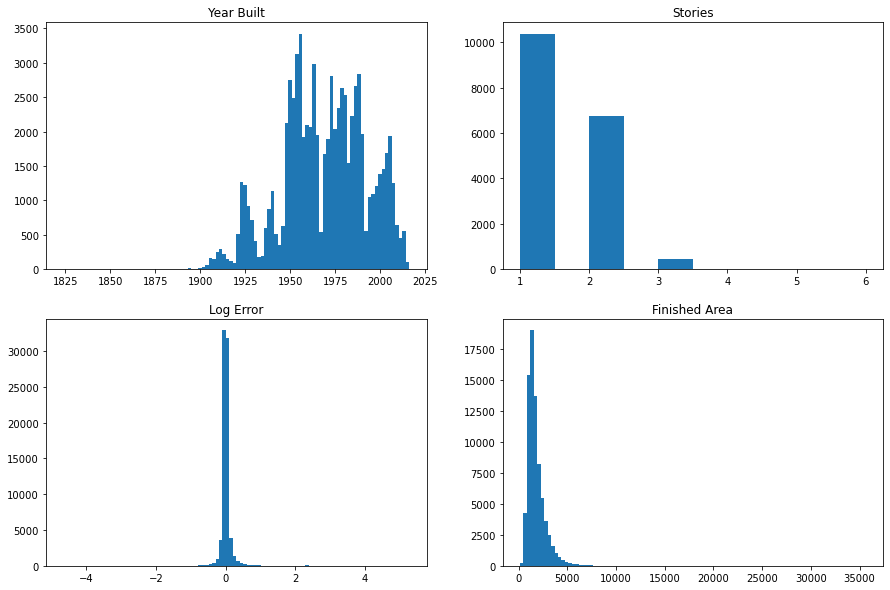

In [13]:
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.hist(df.yearbuilt, bins = 100)
plt.title('Year Built')

plt.subplot(222)
plt.hist(df.numberofstories, bins = 10)
plt.title('Stories')

plt.subplot(223)
plt.hist(df.logerror, bins = 100)
plt.title('Log Error')

plt.subplot(224)
plt.hist(df.calculatedfinishedsquarefeet, bins = 100)
plt.title('Finished Area')

plt.show()

In [9]:
df.isnull().sum().sort_values()

id                                  0
propertylandusedesc                 0
transactiondate                     0
logerror                            0
assessmentyear                      0
roomcnt                             0
regionidcounty                      0
rawcensustractandblock              0
propertylandusetypeid               0
longitude                           0
latitude                            0
fips                                0
propertycountylandusecode           0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
taxvaluedollarcnt                   1
landtaxvaluedollarcnt               2
taxamount                           5
regionidzip                        50
structuretaxvaluedollarcnt        112
calculatedfinishedsquarefeet      196
censustractandblock               244
yearbuilt                         263
fullbathcnt                       609
calculatedbathnbr                 609
regionidcity

In [5]:
def wrangle_zillow():
    ''' 
    This function pulls data from the zillow database from SQL and cleans the data up by changing the column names and romoving rows with null values.  
    Also changes 'fips' and 'year_built' columns into object data types instead of floats, since they are more catergorical, after which the dataframe is saved to a .csv.
    If this has already been done, the function will just pull from the zillow.csv
    '''

    filename = 'zillow.csv'
    
    if os.path.exists(filename):
        print('Reading cleaned data from csv file...')
        return pd.read_csv(filename)